In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline

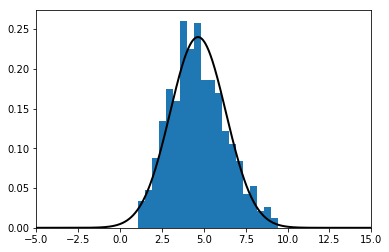

In [2]:
x = np.linspace(-5, 15, 1000)
bet_distribution = np.random.beta(a=6,b=20,size=len(x))*20
mu,std = norm.fit(bet_distribution)
p = norm.pdf(x, mu, std)
plt.hist(bet_distribution, density=True, bins=20);
plt.xlim(-5,15)
plt.plot(x, p, 'k', linewidth=2)

First define a function which can compute any  $\theta$

In [3]:
def generate_prediction(x,pol_p,coef):
    # Function to generate prediction for varied polynomial degrees
    yp = 0
    for ii in range(0,pol_p+1):
        yp = yp+coef[ii]*x**(pol_p-ii)
    return yp


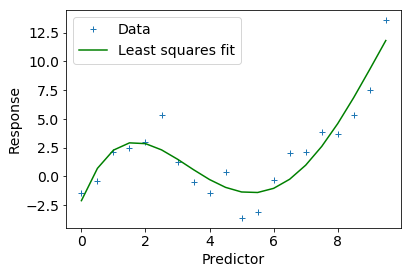

In [103]:
number_of_points = 20
bootstrap_samples = 1000
#polynomial_power
pol_p = 4




x = np.arange(0,10,10/number_of_points)
bot_pct = int(bootstrap_samples*0.05)
top_pct = int(bootstrap_samples*0.95)
median = int(bootstrap_samples*0.5)


noise = np.random.beta(a=6,b=20,size=len(x))*20
noise = noise-np.mean(noise)
noise_gauss = np.random.normal(loc = 0, scale=2, size=len(x))
signal = 2*np.sin(x)+0.001*np.exp(x)
y = signal+noise
coef_ml,res,_,_,_=np.polyfit(x, y, pol_p,full=True)

yp = generate_prediction(x,pol_p,coef_ml)
std_dev_ml = np.sqrt(res/len(sample_x))
data_scatter, = plt.plot(x,y,'+', label = 'Data')
ls_fit, = plt.plot(x,yp,'g',  label = 'Least squares fit');
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.savefig('scatter.png')

In [104]:
def generate_coef_data_non_parametric(distribution_x,distribution_y):
    # Resample from the distribution
    sample_x, sample_y = resample(distribution_x,distribution_y,n_samples=number_of_points)
    # Find coefficients of the polynomial
    coef = np.polyfit(sample_x,sample_y,pol_p)
    # Find the fit
    yp_np = generate_prediction(x,pol_p,coef) 
    return coef,yp_np


def generate_coef_data_parametric(sample_x, sample_y):
    # Find coefficients and residuals from the new data sample
    coef,res,_,_,_=np.polyfit(sample_x, sample_y, pol_p,full=True)
    # Generate noise
    noise= np.random.normal(loc = 0, scale = std_dev_ml, size = number_of_points)
    # Generate new sample of data to fit in 
    signal = generate_prediction(sample_x,pol_p,coef) 
    sample_y = yp+noise
    return coef, sample_y, signal


In [105]:
sample_x = x
sample_y = y
coefv = coef_ml
coefs_p = np.empty((0,pol_p+1),float)
samples_p = np.empty((0,len(x)),float)
predictions_p = np.empty((0,len(x)),float)

coefs_np = np.empty((0,pol_p+1),float)
predictions_np = np.empty((0,len(x)),float)

for ii in range(0,bootstrap_samples):
    coef, yp_np = generate_coef_data_non_parametric(x,y)
    coefv, sample_y, yp_p = generate_coef_data_parametric(sample_x, sample_y)
    
    coefs_p = np.vstack((coefs_p,coefv))
    coefs_np = np.vstack((coefs_np,coef)) 
    predictions_p = np.vstack((predictions_p,yp_p))
    predictions_np = np.vstack((predictions_np,yp_np))


In [106]:
# Generate confidence intervals for predictions

upper_bound_p = np.empty((0),float)
lower_bound_p = np.empty((0),float)
upper_bound_np = np.empty((0),float)
lower_bound_np = np.empty((0),float)
median_p =  np.empty((0),float)
median_np =  np.empty((0),float)
for ii in range(0,predictions_p.shape[1]):
    sorted_pred_p = np.sort(predictions_p[:,ii])
    sorted_pred_np = np.sort(predictions_np[:,ii])
    mean_median_p = yp[ii]#sorted_pred_p[median] # #
    mean_median_np = yp[ii] #sorted_pred_np[median] #
    upper_bound_p = np.append(upper_bound_p, np.array([mean_median_p-sorted_pred_p[bot_pct]]), axis = 0)
    lower_bound_p = np.append(lower_bound_p, np.array([sorted_pred_p[top_pct]-mean_median_p]), axis = 0)
    median_p = np.append(median_p,np.array([sorted_pred_p[median]]))
    upper_bound_np = np.append(upper_bound_np, np.array([mean_median_np-sorted_pred_np[bot_pct]]), axis = 0)
    lower_bound_np = np.append(lower_bound_np, np.array([sorted_pred_np[top_pct]-mean_median_np]), axis = 0)
    median_np = np.append(median_np,np.array([sorted_pred_np[median]]))

In [107]:
## Generate confidence intervals for parameters

coeffs_upper_bound_p = np.empty((0),float)
coeffs_lower_bound_p = np.empty((0),float)
coeffs_upper_bound_np = np.empty((0),float)
coeffs_lower_bound_np = np.empty((0),float)

for ii in range(pol_p,-1,-1):
    coef_sort_p = np.sort(coefs_p[:,ii])
    coef_sort_np = np.sort(coefs_np[:,ii])
    coeffs_upper_bound_p = np.append(coeffs_upper_bound_p, coef_sort_p[median]-coef_sort_p[bot_pct])
    coeffs_lower_bound_p = np.append(coeffs_lower_bound_p, coef_sort_p[top_pct]-coef_sort_p[median])
    coeffs_upper_bound_np = np.append(coeffs_upper_bound_np, coef_sort_np[median]-coef_sort_np[bot_pct])
    coeffs_lower_bound_np = np.append(coeffs_lower_bound_np, coef_sort_np[top_pct]-coef_sort_np[median])



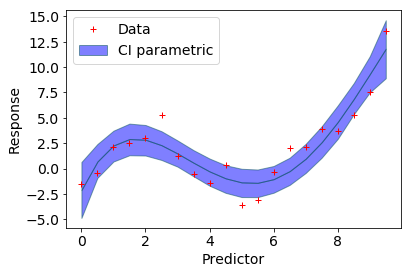

In [108]:
data_scatter, = plt.plot(x,y,'r+', label = 'Data')
# Parametric BLUE
ls_fit= plt.fill_between(x, yp, yp-lower_bound_p, alpha=0.5,edgecolor='#055555', facecolor='blue', label = 'CI parametric')
plt.fill_between(x, yp, yp+upper_bound_p,alpha=0.5,edgecolor='#055555', facecolor='blue')
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.savefig('CI_parametric.png')


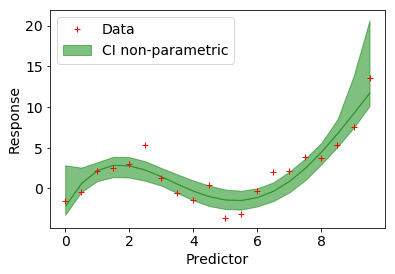

In [109]:
data_scatter, = plt.plot(x,y,'r+', label = 'Data')
# Non-parametric GREEN

ls_fit = plt.fill_between(x, yp, yp-lower_bound_np, alpha=0.5,edgecolor='green', facecolor='green', label = 'CI non-parametric')
plt.fill_between(x, yp, yp+upper_bound_np,alpha=0.5,edgecolor='green', facecolor='green');
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.savefig('CI_non_parametric.png')